# Import

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import select
from revolve2.experimentation.database import OpenMethod, open_database_sqlite

# Set Paths and Column

In [7]:
# Settings
paths = {"CPPN": "C:\\Users\\niels\\Downloads\\CPPN\\Evolution",
         "GRN": "C:\\Users\\niels\\Downloads\\GRN_runs",
         "GRN_system": "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Evolution",}
column = "std_dx"

# Function to set environmental variables

In [8]:
def set_environments(algo, mode):
    # Set environment variables
    file_name = "nan.sqlite"
    assert algo in ["GRN", "GRN_system", "GRN_system_adv", "CPPN"], "ALGORITHM must be either GRN, GRN_system or CPPN"
    assert mode in ["random search", "evolution"], "MODE must be either random search or evolution"
    assert type(file_name) == str, "FILE_NAME must be a string"
    assert file_name.endswith(".sqlite"), "FILE_NAME must end with sqlite"
    os.environ["ALGORITHM"] = algo
    os.environ["MODE"] = mode
    os.environ["DATABASE_FILE"] = file_name

# Columns in Data

In [9]:
# Columns
columns = ["fitness", "energy_used", 
               
               "x_distance", "tot_xdistance", "xmax", "y_distance", "tot_ydistance",
               
               "min_dx", "dx25", "mean_dx", "median_dx", "dx75", "max_dx", "std_dx",
               
               "min_dy", "dy25", "mean_dy", "median_dy", "dy75", "max_dy", "std_dy",
                
                "energy_used_min", "energy_used_25", "energy_used_mean", "energy_used_median",
                "energy_used_75", "energy_used_max", "energy_used_std",

                "force_std_motor_min", "force_std_motor_25", "force_std_motor_mean", "force_std_motor_median",
                "force_std_motor_75", "force_std_motor_max", "force_std_motor_std",

                "force_std_all_min", "force_std_all_25", "force_std_all_mean", "force_std_all_median",
                "force_std_all_75", "force_std_all_max", "force_std_all_std",

                "efficiency", "efficiency_min", "efficiency_25", "efficiency_mean", "efficiency_median",
                "efficiency_75", "efficiency_max", "efficiency_std",

                "balance"]

# Function to select data

In [10]:
def select_data(dbengine, column: str) -> pd.DataFrame:
    """Goal:
        Select the data of the column
    -------------------------------------------------------------
    Input:
        dbengine: ?
        column: The column that needs to be selected
    --------------------------------------------------------------
    Output:
        df: pd.Dataframe"""
    # Load packages
    from experiment import Experiment
    from generation import Generation
    from individual import Individual
    from population import Population
    # Select the data of the column
    df = pd.read_sql(
        select(Experiment.id.label("experiment_id"), Generation.generation_index, getattr(Individual, column),)
        .join_from(Experiment, Generation, Experiment.id == Generation.experiment_id)
        .join_from(Generation, Population, Generation.population_id == Population.id)
        .join_from(Population, Individual, Population.id == Individual.population_id),
        dbengine,
    )

    return df

# Code to Load data

In [11]:
# Initialize dataframe
df = pd.DataFrame([])
# Experiment id
n_exp = 0

# Loop through files
for algo, folder_path in paths.items():
    set_environments(algo, "evolution")
    for file in os.listdir(folder_path):
        if file.endswith(".sqlite"):
            print(file)
            # Open database
            dbengine = open_database_sqlite(folder_path + "\\" + file, open_method=OpenMethod.OPEN_IF_EXISTS)

            # Get pandas data
            if type(column) == list:
                assert column[0] == "x_distance" and column[1] == "tot_xdistance", "Columns must be x_distance ans y_distance"
                df_sub = select_data(dbengine, column[0])
                df_sub.loc[:, "x_ratio"] = select_data(dbengine, column[1])["tot_xdistance"] - df_sub.loc[:, "x_distance"]
                # Fill inf with 0
                df_sub.replace([np.inf, -np.inf], np.nan, inplace = True)
                df_sub.fillna(0, inplace = True)
                df_sub.drop(columns = ["x_distance"], inplace = True)
            else:
                df_sub = select_data(dbengine, column)

            df_sub["experiment_id"] = ((df_sub["experiment_id"] - df_sub["experiment_id"].min()) + n_exp).astype(int).values
            df_sub["Algorithm"] = algo
            print(df_sub["experiment_id"].unique())
            print(df_sub["experiment_id"].shape)
            n_exp = df_sub["experiment_id"].max() + 1

            # Concat data
            df = pd.concat([df, df_sub], axis = 0)

if type(column) == list:
    column = "x_ratio"


database_CPPN_evo1.sqlite
[0 1]
(180200,)
database_CPPN_evo10.sqlite
[2 3]
(180200,)
database_CPPN_evo2.sqlite
[4 5]
(180200,)
database_CPPN_evo3.sqlite
[6 7]
(180200,)
database_CPPN_evo4.sqlite
[8 9]
(180200,)
database_CPPN_evo5.sqlite
[10 11]
(180200,)
database_CPPN_evo6.sqlite
[12 13]
(180200,)
database_CPPN_evo7.sqlite
[14 15]
(180200,)
database_CPPN_evo8.sqlite
[16 17]
(180200,)
database_CPPN_evo9.sqlite
[18 19]
(180200,)
database_GRN_300_1.sqlite
[20 21]
(180200,)
database_GRN_300_10.sqlite
[22 23]
(180200,)
database_GRN_300_2.sqlite
[24 25]
(180200,)
database_GRN_300_3.sqlite
[26 27]
(180200,)
database_GRN_300_4.sqlite
[28 29]
(180200,)
database_GRN_300_5.sqlite
[30 31]
(180200,)
database_GRN_300_6.sqlite
[32 33]
(180200,)
database_GRN_300_7.sqlite
[34 35]
(180200,)
database_GRN_300_8.sqlite
[36 37]
(180200,)
database_GRN_300_9.sqlite
[38 39]
(180200,)
database_GRN_300_1.sqlite
[40]
(90100,)
database_GRN_300_10.sqlite
[41 42]
(180200,)
database_GRN_300_11.sqlite
[43]
(90100,)
da

# Boxplot

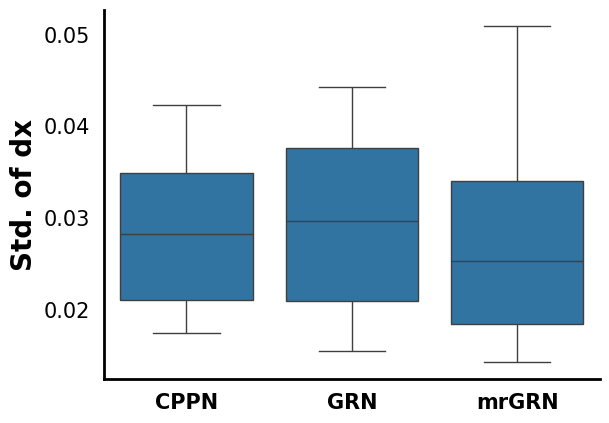

In [12]:
import seaborn as sns
# Select data
df_sub = df[df["Algorithm"].isin(["CPPN", "GRN", "GRN_system"])]
df_sub = df_sub.loc[df_sub["generation_index"] == 1200, :]
# Aggregate over experiments per algorithm to median
df_sub[column] = abs(df_sub[column])
df_sub = df_sub.groupby(["Algorithm", "experiment_id"]).agg({column: "median"}).reset_index()
# Plot
sns.boxplot(x = "Algorithm", y = column, data = df_sub)
# Set labels
plt.xlabel("", fontweight = "bold", size = 20)
#plt.ylabel(column.title(), fontweight = "bold", size = 15)
plt.ylabel("Std. of dx", fontweight = "bold", size = 20)
# Increase spine thickness
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

# Set xtick labels
plt.xticks([0, 1, 2], ["CPPN", "GRN", "mrGRN"], fontweight = "bold")
# Remove ticks
plt.tick_params(axis = "both", which = "both", length = 0)
# Remove top and right spine
sns.despine()
# Increase padding of tick labels
plt.tick_params(axis = "both", which = "both", pad = 10,
                labelsize = 15)
# Set ylim
#plt.ylim(2, 14)
#plt.ylim(0.01, 0.06)
#plt.ylim(-0.1, 2)

plt.show()
